## Model Results

In this notebook, we investigate the results of model configurations constructed and compiled with several different grid implementations.

To begin, let's by import some necessary modules:

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

### Model Results without MPI

For the first example, we will start with the most basic example, taking a look at the model results without MPI. Here, we will define some characteristics of the model and the model grid

In [21]:
# model grid parameters
n_rows = 62
n_cols = 62
n_depth_levels = 1
max_number_of_icebergs = 4
model_timestep = 1200

# model grid indices
cols = np.arange(1,n_cols+1)-0.5
rows = np.arange(1,n_rows+1)-0.5
Cols, Rows = np.meshgrid(cols,rows)

# model grid cartesian coordinates
x = 20e3*np.arange(n_cols)-20e3
y = 20e3*np.arange(n_rows)-20e3
X,Y = np.meshgrid(x,y)

Next, define the location of the run directory for this model:

In [22]:
run_dir = '../../../../example_configs/cold_barotropic_gyre/run'

This model has been compiled and run in the previous notebook.

Next, we define a function to read in the iceberg files generated during the model run. Note that the model was run for 100 days in this model run, according to the default parameters in the provided files, but this function will work for up to 366 days:

In [23]:
def read_iceberg_results(run_dir):
    # make arrays to hold the dimensions
    timesteps = []
    max_timesteps = 366
    widths = np.zeros((max_number_of_icebergs, max_timesteps))
    lengths = np.zeros((max_number_of_icebergs, max_timesteps))
    thicknesses = np.zeros((max_number_of_icebergs, max_timesteps))
    locations = np.zeros((max_number_of_icebergs, max_timesteps, 2))
    indices = np.zeros((max_number_of_icebergs, max_timesteps, 2))
    tiles = np.zeros((max_number_of_icebergs, max_timesteps))
    
    # read in the dimensions one by one
    timestep_counter = 0
    for file_name in sorted(os.listdir(os.path.join(run_dir,'diags','iceberg'))):
        if file_name.startswith('iceberg'):
            output_grid = np.fromfile(os.path.join(run_dir,'diags','iceberg',file_name),'>f8')
            output_grid = output_grid.reshape((17, max_number_of_icebergs)).T
            timesteps.append(int(file_name.split('.')[-2]))
            for iceberg_ID in range(1,5):
                iceberg_index = np.where(output_grid[:,0]==iceberg_ID)[0]
                indices[iceberg_index, timestep_counter, 0] = output_grid[iceberg_index, 2]
                indices[iceberg_index, timestep_counter, 1] = output_grid[iceberg_index, 3]
                locations[iceberg_index, timestep_counter, 0] = output_grid[iceberg_index, 4]
                locations[iceberg_index, timestep_counter, 1] = output_grid[iceberg_index, 5]
                widths[iceberg_index, timestep_counter] = output_grid[iceberg_index, 6]
                lengths[iceberg_index, timestep_counter] = output_grid[iceberg_index, 7]
                thicknesses[iceberg_index, timestep_counter] = output_grid[iceberg_index, 8]
                tiles[iceberg_index, timestep_counter] = output_grid[iceberg_index, 1]
            timestep_counter += 1
    
    # convert time to days
    time = np.array(timesteps)*model_timestep/86400
    
    # remove zeros
    widths = widths[:,:len(time)]
    lengths = lengths[:,:len(time)]
    thicknesses = thicknesses[:,:len(time)]
    locations = locations[:, :len(time), :]
    indices = indices[:, :len(time), :]
    tiles = tiles[:,:len(time)]
    
    # move tile indices to global indices for the purposes of this example
    if 'mpi' in run_dir:
        for iceberg_ID in range(1,5):
            if 'exch2' in run_dir:
                indices[iceberg_ID-1, tiles[iceberg_ID-1,:]==1, 0] += 31
                indices[iceberg_ID-1, tiles[iceberg_ID-1,:]==2, 1] += 31
            else:
                indices[iceberg_ID-1, tiles[iceberg_ID-1,:]==1, 1] += 31
                indices[iceberg_ID-1, tiles[iceberg_ID-1,:]==2, 0] += 31
            indices[iceberg_ID-1, tiles[iceberg_ID-1,:]==3, 0] += 31
            indices[iceberg_ID-1, tiles[iceberg_ID-1,:]==3, 1] += 31
            
    return(time, locations, indices, tiles, widths, lengths, thicknesses)

Using the above function, we read in the results from the model results compiled without MPI:

In [24]:
time, locations, indices, tiles, widths, lengths, thicknesses = read_iceberg_results(run_dir)

In addition, we will also read in the velocity field from the pickup file. This will give us a sense for the model velocity fields as the model is in near-steady state:

In [25]:
# pickup
pickup = np.fromfile('../../../../example_configs/cold_barotropic_gyre/run/pickup.0000000001.data','>f8').reshape((9, n_rows,n_cols))

# get the velocity fields
u_vel = pickup[0,:,:]
v_vel = pickup[1,:,:]

# compute the speed as a grid
speed_grid = (u_vel**2 + v_vel**2)**0.5

With the above fields we can make a plot of the model results

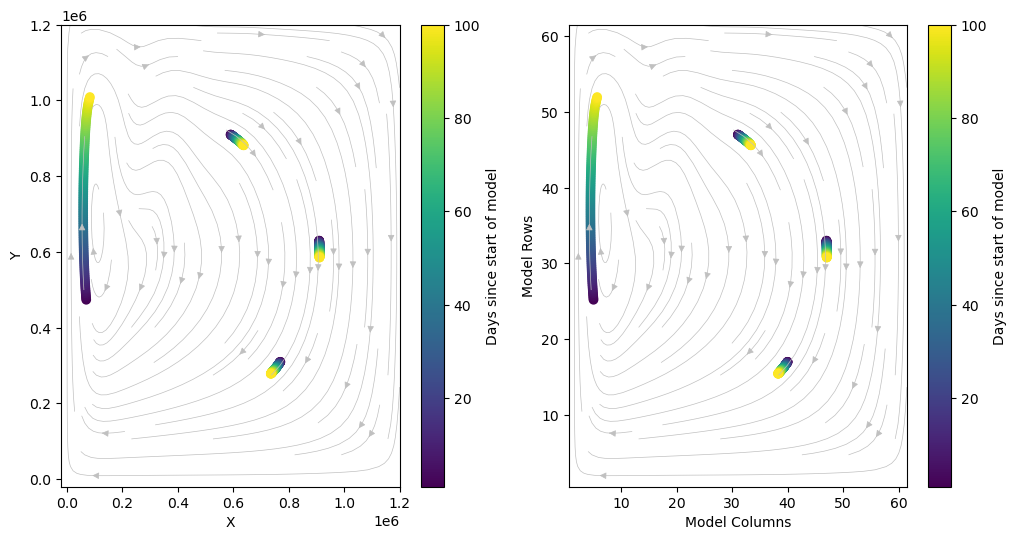

In [26]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)

plt.streamplot(X, Y, u_vel, v_vel, linewidth=0.5, color='silver')

for iceberg_ID in range(4):
    C = plt.scatter(locations[iceberg_ID,:,0], locations[iceberg_ID,:,1], c=time)#,

plt.colorbar(C, label='Days since start of model')
plt.xlabel('X')
plt.ylabel('Y')


plt.subplot(1,2,2)

plt.streamplot(Cols, Rows, u_vel, v_vel, linewidth=0.5, color='silver')

for iceberg_ID in range(4):
    C = plt.scatter(indices[iceberg_ID,:,0], indices[iceberg_ID,:,1], c=time)#,

plt.colorbar(C, label='Days since start of model')
plt.xlabel('Model Columns')
plt.ylabel('Model Rows')
plt.show()

As we can see, the iceberg follows the stream lines. This effect is achieved since the model is run with the `USE_LAGARANGIAN_FLOATS` option in the `ICEBERG_OPTIONS.h` file. In this set up, the model only considers the water velocity when advecting the icebergs - not any of the other effects including the wind speed and the Coriolis effect.

### Results with MPI

Now that the base case has been estabilished, we will look at the results when the model is compiled with MPI. When using MPI, the processing tiles are organized into columns and rows, counting sequentially from 0 to `nPx*nPY-1`. In this configuration, the icebergs need to be "exchanged" from one processor to another when they cross the boundary of a given tile.

Let's define the run directory for this model and read in the results using the function defined above:

In [27]:
run_dir_mpi = '../../../../example_configs/cold_barotropic_gyre/run_mpi'

time_mpi, locations_mpi, indices_mpi, tiles_mpi, widths_mpi, lengths_mpi, thicknesses_mpi = \
     read_iceberg_results(run_dir_mpi)

Let's plot the results to ensure the locations are identical to the case without icebergs:

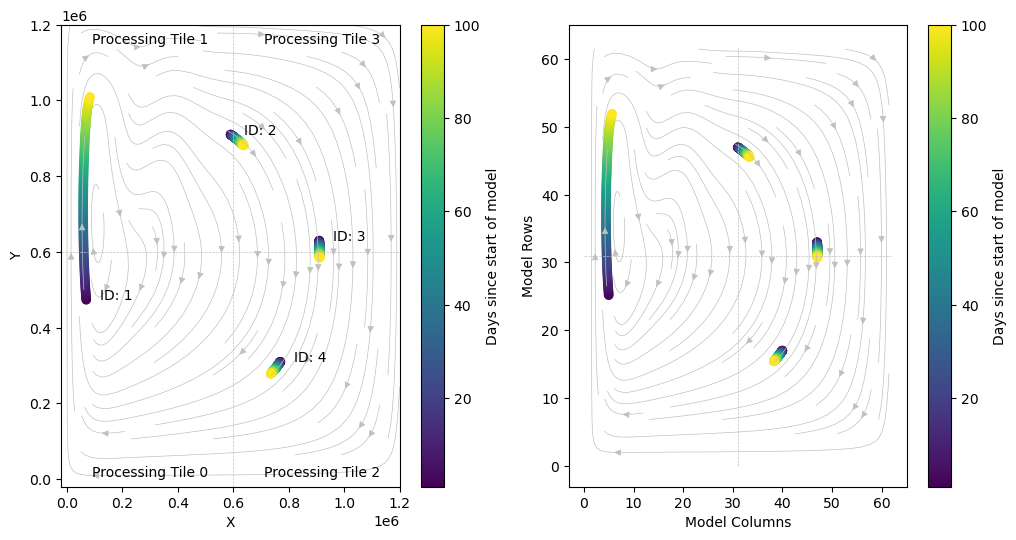

In [30]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)

plt.streamplot(X, Y, u_vel, v_vel, linewidth=0.5, color='silver')

for iceberg_ID in range(4):
    C = plt.scatter(locations_mpi[iceberg_ID,:,0], locations_mpi[iceberg_ID,:,1], c=time_mpi)

    plt.text(locations_mpi[iceberg_ID,0,0] + 50000,
             locations_mpi[iceberg_ID,0,1], 'ID: '+str(iceberg_ID+1))

plt.text(X[1,16], Y[1,16], 'Processing Tile 0', ha='center', va='bottom')
plt.text(X[-2,16], Y[-2,7], 'Processing Tile 1', ha='center', va='top')
plt.text(X[1,47], Y[1,47], 'Processing Tile 2', ha='center', va='bottom')
plt.text(X[-2,47], Y[-2,47], 'Processing Tile 3', ha='center', va='top')

plt.plot(X[:,31],Y[:,31],'--',color='silver', linewidth=0.5)
plt.plot(X[31, :],Y[31, :],'--',color='silver', linewidth=0.5)

plt.colorbar(C, label='Days since start of model')
plt.xlabel('X')
plt.ylabel('Y')


plt.subplot(1,2,2)

plt.streamplot(Cols, Rows, u_vel, v_vel, linewidth=0.5, color='silver')

for iceberg_ID in range(4):
    C = plt.scatter(indices_mpi[iceberg_ID,:,0], indices_mpi[iceberg_ID,:,1], c=time_mpi)

plt.plot([0,62],[31,31],'--',color='silver', linewidth=0.5)
plt.plot([31, 31],[0,62],'--',color='silver', linewidth=0.5)

plt.colorbar(C, label='Days since start of model')
plt.xlabel('Model Columns')
plt.ylabel('Model Rows')
plt.show()

As we can see in the plots above, the icebergs change tiles during the model run and the underlying code keeps track of these changes and the location in the global grid. These tile exchanges are recorded in the output diagnostics, which we can observe below:

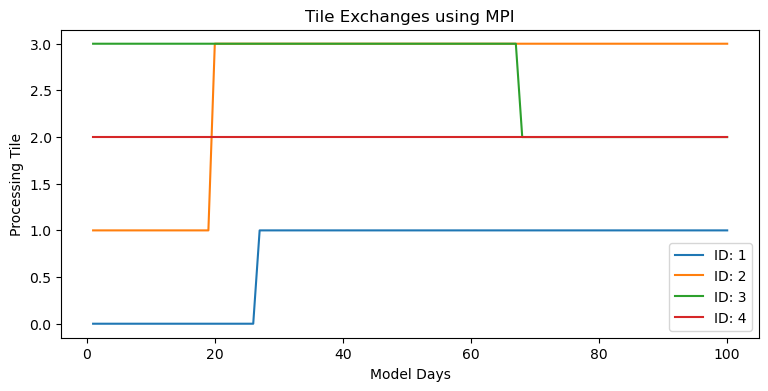

In [29]:
plt.figure(figsize=(9,4))

for iceberg_ID in range(4):
    plt.plot(time_mpi, tiles_mpi[iceberg_ID, :], label='ID: '+str(iceberg_ID+1))
    
plt.ylabel('Processing Tile')
plt.xlabel('Model Days')
plt.title('Tile Exchanges using MPI')
plt.legend()
    
plt.show()

## Results with MPI and Exch2

Up next, we look at the results when compiling with the `exch2` package. When using `exch2` the tiles are counted in rows, left to right, and then up in columns. This needs to be dealt with differently than in the generic MPI case. Again, let's define the run directory and read in the results:

In [12]:
run_dir_mpi_exch2 = '../../../../example_configs/cold_barotropic_gyre/run_mpi_exch2'

time_mpi_exch2, locations_mpi_exch2, indices_mpi_exch2, tiles_mpi_exch2, \
widths_mpi_exch2, lengths_mpi_exch2, thicknesses_mpi_exch2 = \
read_iceberg_results(run_dir_mpi_exch2)

Again, let's plot the results:

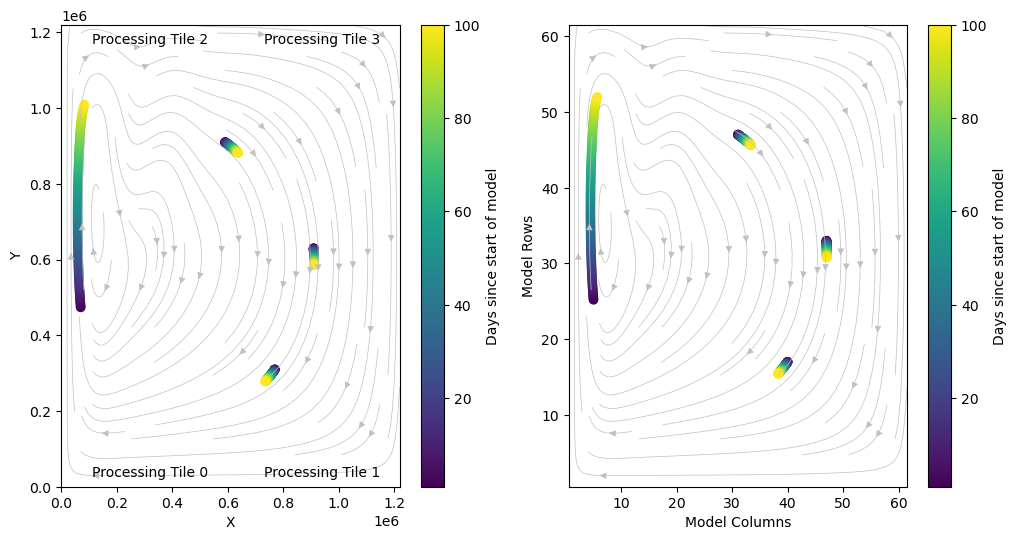

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)

plt.streamplot(X, Y, u_vel, v_vel, linewidth=0.5, color='silver')

for iceberg_ID in range(4):
    C = plt.scatter(locations_mpi_exch2[iceberg_ID,:,0], locations_mpi_exch2[iceberg_ID,:,1], c=time_mpi_exch2)

plt.text(X[1,16], Y[1,16], 'Processing Tile 0', ha='center', va='bottom')
plt.text(X[-2,16], Y[-2,7], 'Processing Tile 2', ha='center', va='top')
plt.text(X[1,47], Y[1,47], 'Processing Tile 1', ha='center', va='bottom')
plt.text(X[-2,47], Y[-2,47], 'Processing Tile 3', ha='center', va='top')

plt.colorbar(C, label='Days since start of model')
plt.xlabel('X')
plt.ylabel('Y')


plt.subplot(1,2,2)

plt.streamplot(Cols, Rows, u_vel, v_vel, linewidth=0.5, color='silver')

for iceberg_ID in range(4):
    C = plt.scatter(indices_mpi_exch2[iceberg_ID,:,0], indices_mpi_exch2[iceberg_ID,:,1], c=time_mpi_exch2)#,

plt.colorbar(C, label='Days since start of model')
plt.xlabel('Model Columns')
plt.ylabel('Model Rows')
plt.show()

Again, the output will keep track of the processing tiles:

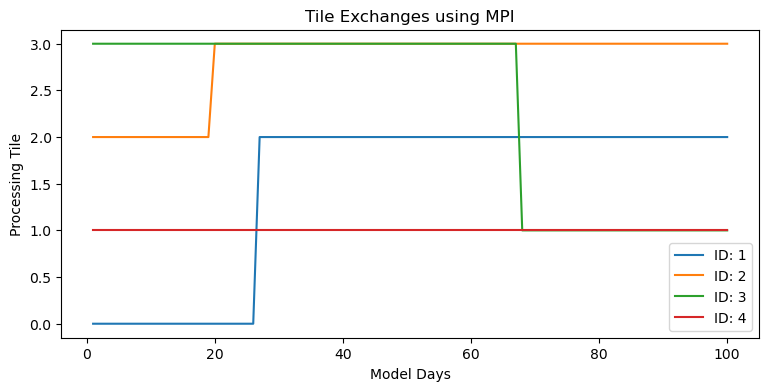

In [14]:
plt.figure(figsize=(9,4))

for iceberg_ID in range(4):
    plt.plot(time_mpi_exch2, tiles_mpi_exch2[iceberg_ID, :], label='ID: '+str(iceberg_ID+1))
    
plt.ylabel('Processing Tile')
plt.xlabel('Model Days')
plt.title('Tile Exchanges using MPI')
plt.legend()
    
plt.show()

As we can see, the results are similar to those above. However, the several of the processing tiles are swapped.

## Results with MPI and Exch2 and a Blank List

In [31]:
run_dir_mpi_exch2_blank = '../../../../example_configs/cold_barotropic_gyre/run_mpi_exch2_blank'

time_mpi_exch2_blank, locations_mpi_exch2_blank, indices_mpi_exch2_blank, tiles_mpi_exch2_blank, \
widths_mpi_exch2_blank, lengths_mpi_exch2_blank, thicknesses_mpi_exch2_blank = \
read_iceberg_results(run_dir_mpi_exch2_blank)

And plot:

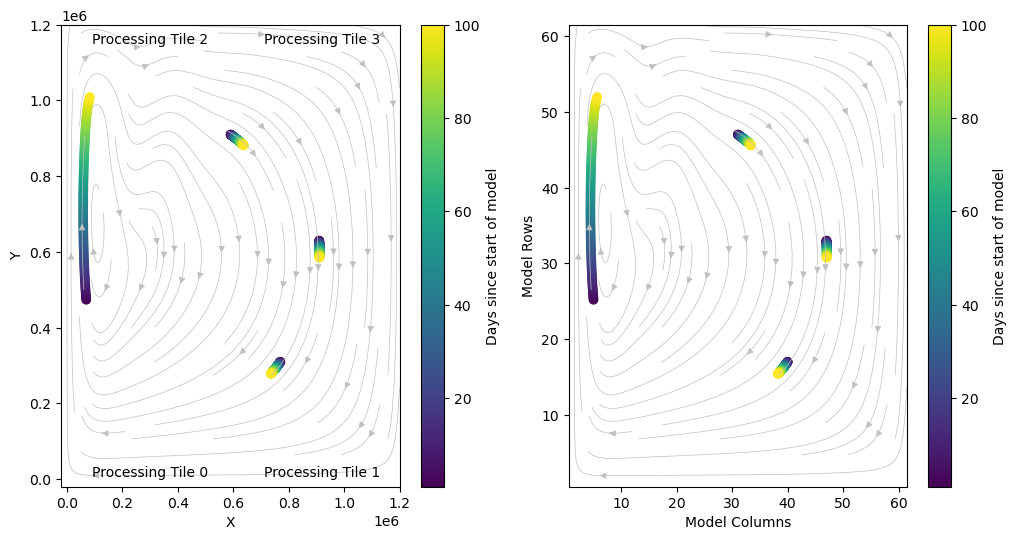

In [32]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)

plt.streamplot(X, Y, u_vel, v_vel, linewidth=0.5, color='silver')

for iceberg_ID in range(4):
    C = plt.scatter(locations_mpi_exch2_blank[iceberg_ID,:,0],
                    locations_mpi_exch2_blank[iceberg_ID,:,1], c=time_mpi_exch2_blank)

plt.text(X[1,16], Y[1,16], 'Processing Tile 0', ha='center', va='bottom')
plt.text(X[-2,16], Y[-2,7], 'Processing Tile 2', ha='center', va='top')
plt.text(X[1,47], Y[1,47], 'Processing Tile 1', ha='center', va='bottom')
plt.text(X[-2,47], Y[-2,47], 'Processing Tile 3', ha='center', va='top')

plt.colorbar(C, label='Days since start of model')
plt.xlabel('X')
plt.ylabel('Y')


plt.subplot(1,2,2)

plt.streamplot(Cols, Rows, u_vel, v_vel, linewidth=0.5, color='silver')

for iceberg_ID in range(4):
    C = plt.scatter(indices_mpi_exch2_blank[iceberg_ID,:,0],
                    indices_mpi_exch2_blank[iceberg_ID,:,1], c=time_mpi_exch2_blank)#,

plt.colorbar(C, label='Days since start of model')
plt.xlabel('Model Columns')
plt.ylabel('Model Rows')
plt.show()

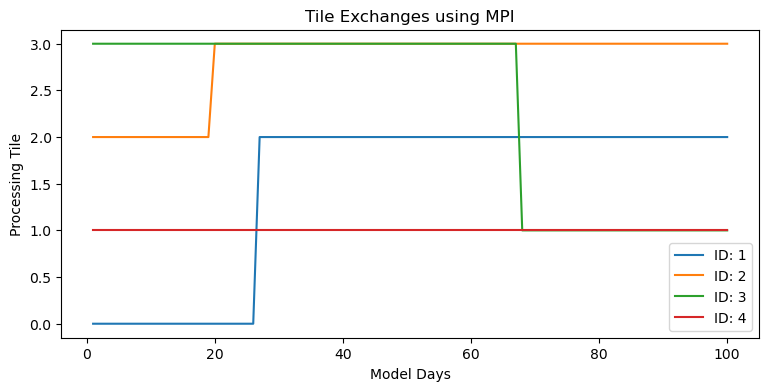

In [33]:
plt.figure(figsize=(9,4))

for iceberg_ID in range(4):
    plt.plot(time_mpi_exch2_blank, tiles_mpi_exch2_blank[iceberg_ID, :], label='ID: '+str(iceberg_ID+1))
    
plt.ylabel('Processing Tile')
plt.xlabel('Model Days')
plt.title('Tile Exchanges using MPI')
plt.legend()
    
plt.show()